# Checkpoint 2 Notebook

__TODO__:
- fill this cell in with info, results, insights from our EDA 
- preprocess: create preprocessing pipeline, store all code into script, then run script to preprocess all data and store into pickle
- analysis: need "3 hypothesis tests" to validate hypotheses

### Preprocessing

In [61]:
# ------------- imports ------------- #
import polars as pl
import numpy as np
import os
import librosa
import scipy.signal as signal
import polars as pl
import soundfile as sf 
from typing import Union, List, Dict
import json
import time

# ------------ macros ------------ #
SAMPLE_RATE = 16e3
ORG_CSV_PATH = 'ReCANVo/dataset_file_directory.csv'
RENAME_CSV_PATH = 'ReCANVo/renamed_metadata.csv'
AUDIO_DIR = 'ReCANVo/'


# ----------------------- preprocessing functions ----------------------- #
import numpy as np
import librosa
import soundfile as sf  # Added soundfile for audio writing
import scipy.signal as signal
import os

def save_audio_comparison(original_y: np.ndarray, 
                           cleaned_y: np.ndarray, 
                           sr: int, 
                           filename: str, 
                           output_dir: str = 'audio_comparisons') -> None:
    """
    Save original and cleaned audio files for side-by-side comparison.

    Parameters:
        original_y (np.ndarray): Original audio time series
        cleaned_y (np.ndarray): Cleaned audio time series
        sr (int): Sampling rate
        filename (str): Base filename for saved audio files
        output_dir (str): Directory to save comparison audio files
    """
    os.makedirs(output_dir, exist_ok=True)
    base_name = os.path.splitext(filename)[0]
    original_path = os.path.join(output_dir, f"{base_name}_original.wav")
    cleaned_path = os.path.join(output_dir, f"{base_name}_cleaned.wav")

    sf.write(original_path, original_y, sr)
    sf.write(cleaned_path, cleaned_y, sr)

def clean_audio(y: np.ndarray, 
                sr: int, 
                denoise: bool = True, 
                remove_silence: bool = True,
                normalize: bool = True,
                min_silence_duration: float = 0.3,
                silence_threshold: float = -40) -> np.ndarray:
    """
    Enhanced audio cleaning function tailored for voice recordings of autistic individuals.

    Parameters:
        y (np.ndarray): Input audio time series
        sr (int): Sampling rate
        denoise (bool): Apply noise reduction
        remove_silence (bool): Remove long silent segments
        normalize (bool): Normalize audio amplitude
        min_silence_duration (float): Minimum duration of silence to remove (in seconds)
        silence_threshold (float): Decibel threshold for silence detection

    Returns:
        np.ndarray: Cleaned audio time series
    """
    cleaned_audio = y.copy()

    if normalize:
        cleaned_audio = librosa.util.normalize(cleaned_audio)

    # Noise reduction using spectral gating
    if denoise:
        # Compute short-time Fourier transform (STFT)
        stft = librosa.stft(cleaned_audio)
        
        # Compute magnitude and phase
        mag, phase = librosa.magphase(stft)
        
        # Compute the noise threshold
        noise_threshold = np.median(mag) * 0.5
        
        # Create a soft mask to reduce noise
        mask = mag > noise_threshold
        
        # Apply the mask
        cleaned_stft = stft * mask
        
        # Convert back to time domain
        cleaned_audio = librosa.istft(cleaned_stft)

    # Remove long silent segments
    if remove_silence:
        # Compute the frame size and hop length for silence detection
        frame_length = int(sr * min_silence_duration)
        hop_length = frame_length // 2

        # Detect non-silent frames
        non_silent_frames = librosa.effects.split(
            cleaned_audio, 
            top_db=abs(silence_threshold), 
            frame_length=frame_length, 
            hop_length=hop_length
        )

        # Reconstruct audio from non-silent segments
        cleaned_audio = np.concatenate([
            cleaned_audio[start:end] for start, end in non_silent_frames
        ])

    # Apply gentle high-pass filter to reduce low-frequency noise
    b, a = signal.butter(6, 80 / (sr/2), btype='high')
    cleaned_audio = signal.filtfilt(b, a, cleaned_audio)

    return cleaned_audio

def load_audio_metadata(csv_path: str,
                        audio_dir: str,
                        limit: Union[int, None] = None,
                        clean_audio_params: dict = None,
                        save_comparisons: bool = False,
                        comparison_dir: str = 'audio_comparisons') -> pl.DataFrame:
    """
    Loads audio files from directory and returns a DataFrame with cleaned waveform and metadata.

    Args:
        csv_path (str): Path to the CSV file containing data.
        audio_dir (str): Directory where audio files are stored.
        limit (int, optional): Number of rows to load. If None, loads all.
        clean_audio_params (dict, optional): Parameters for audio cleaning.
        save_comparisons (bool): Whether to save original vs cleaned audio files
        comparison_dir (str): Directory to save comparison audio files

    Returns:
        pl.DataFrame: DataFrame with columns: Filename, Audio, ID, Label, Duration, Index
    """
    df = pl.read_csv(csv_path)
    if limit:
        df = df.head(limit)

    # Default cleaning parameters if not provided
    default_clean_params = {
        'denoise': True,
        'remove_silence': True,
        'normalize': True,
        'min_silence_duration': 0.3,
        'silence_threshold': -40
    }
    clean_params = default_clean_params if clean_audio_params is None else {**default_clean_params, **clean_audio_params}

    audio_data = []

    if save_comparisons is True:
        comparison_count = len(df)  
    else:
        comparison_count = 0  

    for idx, row in enumerate(df.iter_rows(named=True)):
        file_name = row['Filename']
        file_path = os.path.join(audio_dir, file_name)

        # Load original audio
        y, sr = librosa.load(file_path, sr=None)
        
        # Clean audio
        cleaned_y = clean_audio(y, sr, **clean_params)

        if save_comparisons and idx < comparison_count:
            save_audio_comparison(
                original_y=y, 
                cleaned_y=cleaned_y, 
                sr=sr, 
                filename=file_name,
                output_dir=comparison_dir
            )
        
        duration = len(cleaned_y) / sr

        audio_data.append((
            file_name,
            cleaned_y.tolist(),
            row['ID'],
            row['Label'],
            duration,
            row['Index']
        ))

    audio_df = pl.DataFrame(
        audio_data,
        schema=["Filename", "Audio", "ID", "Label", "Duration", "Index"],
        orient='row'
    )

    return audio_df


def rename_audio_files(csv_path: str,
                       audio_dir: str,
                       output_csv: str = "renamed_metadata.csv") -> None:
    """
    Renames audio files based on Participant and Label and saves new metadata.

    Args:
        csv_path (str): Path to the input metadata CSV.
        audio_dir (str): Directory containing audio files.
        output_csv (str): Filename for the output metadata CSV.
    """
    df = pl.read_csv(csv_path)
    renamed_files = []
    file_counts = {}

    for file in df.iter_rows(named=True):
        org_name = file['Filename']
        id = file['Participant']
        label = file['Label']

        key = (id, label)
        file_counts[key] = file_counts.get(key, 0) + 1
        index = file_counts[key]

        new_name = f"{id}_{label}_{index}.wav"
        old_path = os.path.join(audio_dir, org_name)
        new_path = os.path.join(audio_dir, new_name)

        if not os.path.exists(old_path):
            print(f"❌ File not found: {old_path}. Skipping renaming process.")
            return  # Exit the function immediately if any file is missing

        os.rename(old_path, new_path)
        renamed_files.append((new_name, id, label, index))

    # If renaming was successful, save the updated metadata
    renamed_df = pl.DataFrame(renamed_files, schema=["Filename", "ID", "Label", "Index"], orient="row")
    output_path = os.path.join(audio_dir, output_csv)
    renamed_df.write_csv(output_path)
    

def compute_or_load_global_stats(ys: List[np.ndarray],
                                 sr: int,
                                 n_mels: int = 128,
                                 method: str = "zscore",
                                 stats_file: str = "global_stats.json",
                                 force_recompute: bool = False) -> Dict[str, float]:
    """
    Computes or loads global normalization stats for Mel spectrograms.

    Parameters:
        ys (List[np.ndarray]): List of raw audio waveforms.
        sr (int): Sample rate.
        n_mels (int): Number of Mel bands.
        method (str): 'zscore' or 'minmax'.
        stats_file (str): Path to save/load stats JSON.
        force_recompute (bool): If True, recomputes even if file exists.

    Returns:
        Dict[str, float]: Stats dictionary (mean/std or min/max).
    """

    if not force_recompute and os.path.exists(stats_file):
        print(f"🗂️ Loading global stats from {stats_file}")
        with open(stats_file, "r") as f:
            return json.load(f)

    print(f"📊 Computing global stats with method '{method}'...")
    all_values = []

    for y in ys:
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        S_db = librosa.power_to_db(S, ref=np.max)
        all_values.append(S_db.flatten())

    all_values = np.concatenate(all_values)
    stats = {}

    if method == "zscore":
        stats = {
            "mean": float(np.mean(all_values)),
            "std": float(np.std(all_values))
        }
    elif method == "minmax":
        stats = {
            "min": float(np.min(all_values)),
            "max": float(np.max(all_values))
        }
    else:
        raise ValueError("Unsupported method. Use 'zscore' or 'minmax'.")

    # Save stats to file
    with open(stats_file, "w") as f:
        json.dump(stats, f)
        print(f"💾 Saved global stats to {stats_file}")

    return stats



def audio_to_spectrogram(y: np.ndarray,
                         sr: int,
                         n_mels: int = 128,
                         target_length: int = 128,
                         normalization: str = "minmax",
                         normalize_scope: str = "sample",  # "sample" or "global"
                         global_stats: dict = None) -> np.ndarray:
    """
    Converts a raw audio waveform into a normalized, fixed-size Mel spectrogram.

    Parameters:
        y (np.ndarray): Raw audio waveform.
        sr (int): Sample rate of the audio.
        n_mels (int): Number of Mel bands.
        target_length (int): Number of time steps to pad/crop to.
        normalization (str): 'minmax' or 'zscore'.
        normalize_scope (str): 'sample' for per-sample normalization,
                               'global' for dataset-wide using global_stats.
        global_stats (dict): Required if normalize_scope='global'. Should contain
                             'mean' and 'std' or 'min' and 'max'.

    Returns:
        np.ndarray: Mel spectrogram of shape (n_mels, target_length).
    """

    def _normalize(S_db: np.ndarray, method: str, scope: str, stats: dict = None):
        if scope == "sample":
            if method == "minmax":
                return (S_db - S_db.min()) / (S_db.max() - S_db.min())
            elif method == "zscore":
                mean = np.mean(S_db)
                std = np.std(S_db)
                return (S_db - mean) / std
        elif scope == "global":
            if stats is None:
                raise ValueError("Global normalization requires global_stats.")
            if method == "minmax":
                return (S_db - stats["min"]) / (stats["max"] - stats["min"])
            elif method == "zscore":
                return (S_db - stats["mean"]) / stats["std"]
        else:
            raise ValueError("Unsupported normalization scope. Use 'sample' or 'global'.")

    def _pad_or_crop(S: np.ndarray, target_len: int):
        current_len = S.shape[1]
        if current_len < target_len:
            pad_width = target_len - current_len
            return np.pad(S, ((0, 0), (0, pad_width)), mode='constant')
        else:
            return S[:, :target_len]

    # Compute Mel spectrogram and convert to dB
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Normalize
    S_norm = _normalize(S_db, method=normalization, scope=normalize_scope, stats=global_stats)

    # Fix shape
    S_fixed = _pad_or_crop(S_norm, target_len=target_length)

    return S_fixed


def pipeline(rename: bool=False, 
             limit: Union[int, None] = None,
             clean_audio_params: dict = None,
             save_comparisons: bool = False):
    """
    Pipeline to run all preprocessing functions with timing and optional audio cleaning.
    """
    print("🚀 Starting preprocessing pipeline...")
    start = time.time()
    
    # Step 1: Rename files
    if rename:
        t0 = time.time()
        rename_audio_files(
            csv_path=ORG_CSV_PATH,
            audio_dir=AUDIO_DIR,
        )
        print(f"📝 rename_audio_files completed in {time.time() - t0:.2f} seconds")

    # Step 2: Load audio metadata with cleaning
    t0 = time.time()
    df = load_audio_metadata(
        csv_path=RENAME_CSV_PATH,
        audio_dir=AUDIO_DIR,
        limit=limit,
        clean_audio_params=clean_audio_params,
        save_comparisons=save_comparisons
    )
    print(f"⏳ load_audio_metadata completed in {time.time() - t0:.2f} seconds")

    # Step 3: Compute or load global stats
    t0 = time.time()
    stats = compute_or_load_global_stats(df["Audio"].to_numpy(), sr=SAMPLE_RATE)
    print(f"🧮 compute_or_load_global_stats completed in {time.time() - t0:.2f} seconds")
    
    print("\n📈 Computed Statistics:")
    for k, v in stats.items(): 
        print(f"  {k}: {v}")
    print()

    # Step 4: Compute spectrograms
    t0 = time.time()
    df = df.with_columns([
        pl.col("Audio").map_elements(lambda y: audio_to_spectrogram(
            y=np.array(y),
            sr=SAMPLE_RATE,
            normalization='zscore',
            normalize_scope='global',
            global_stats=stats
        ), return_dtype=pl.Object).alias("Spectrogram")
    ])
    print(f"🔊 Spectrogram generation completed in {time.time() - t0:.2f} seconds")

    # Done
    print(f"\n🏁 Full pipeline completed in {time.time() - start:.2f} seconds\n")
    print(df)
    return df

In [62]:
custom_clean_params = {
    'denoise': False,
    'remove_silence': False,
    'min_silence_duration': 0.5,
    'silence_threshold': -35
}

df = pipeline(
    rename=False, 
    limit=None,
    clean_audio_params=custom_clean_params,
    save_comparisons=False
)

🚀 Starting preprocessing pipeline...
⏳ load_audio_metadata completed in 191.90 seconds
🗂️ Loading global stats from global_stats.json
🧮 compute_or_load_global_stats completed in 0.19 seconds

📈 Computed Statistics:
  mean: -55.975612227106474
  std: 18.55726476893056

🔊 Spectrogram generation completed in 29.64 seconds

🏁 Full pipeline completed in 221.75 seconds

shape: (7_077, 7)
┌───────────────────┬──────────────┬─────┬───────────────────┬──────────┬───────┬──────────────────┐
│ Filename          ┆ Audio        ┆ ID  ┆ Label             ┆ Duration ┆ Index ┆ Spectrogram      │
│ ---               ┆ ---          ┆ --- ┆ ---               ┆ ---      ┆ ---   ┆ ---              │
│ str               ┆ list[f64]    ┆ str ┆ str               ┆ f64      ┆ i64   ┆ object           │
╞═══════════════════╪══════════════╪═════╪═══════════════════╪══════════╪═══════╪══════════════════╡
│ P01_dysregulation ┆ [-0.107679,  ┆ P01 ┆ dysregulation-sic ┆ 0.263991 ┆ 1     ┆ [[ 1.71382742    │
│ -sick_1

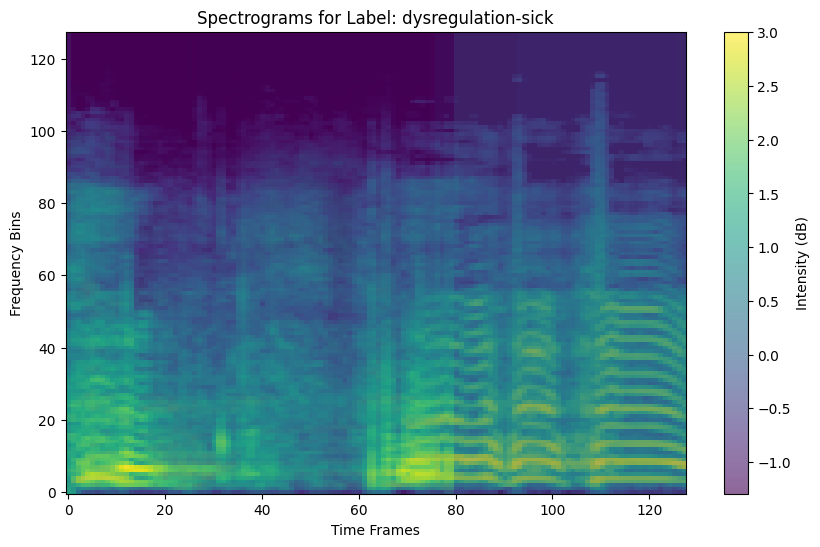

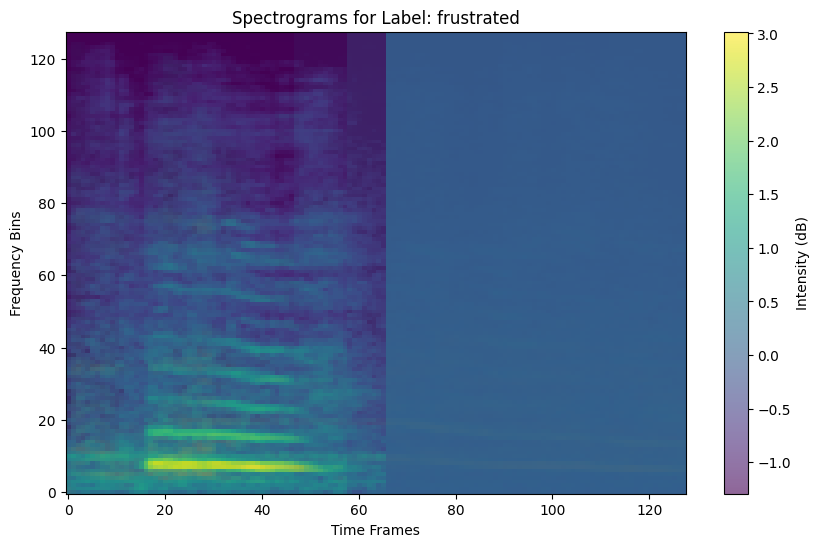

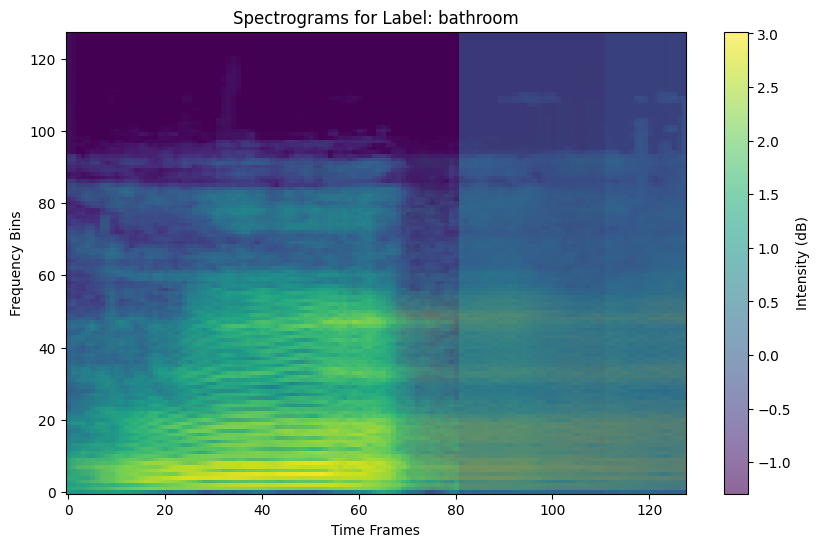

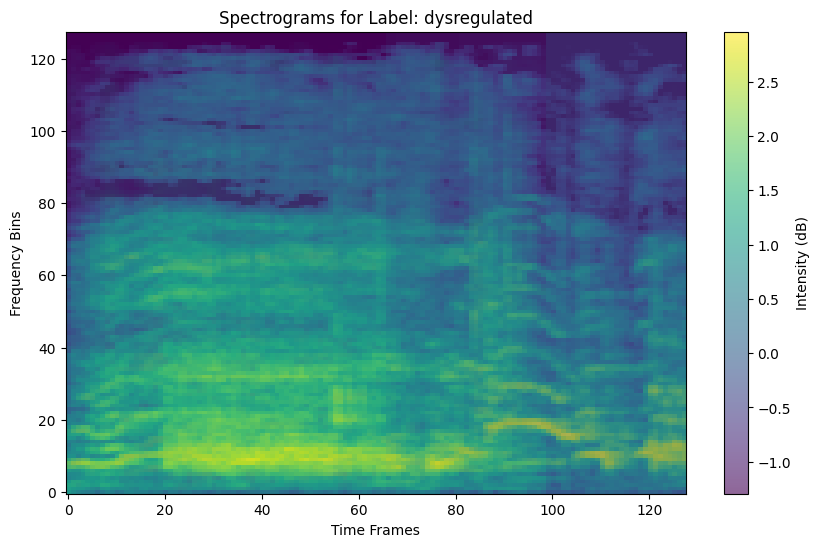

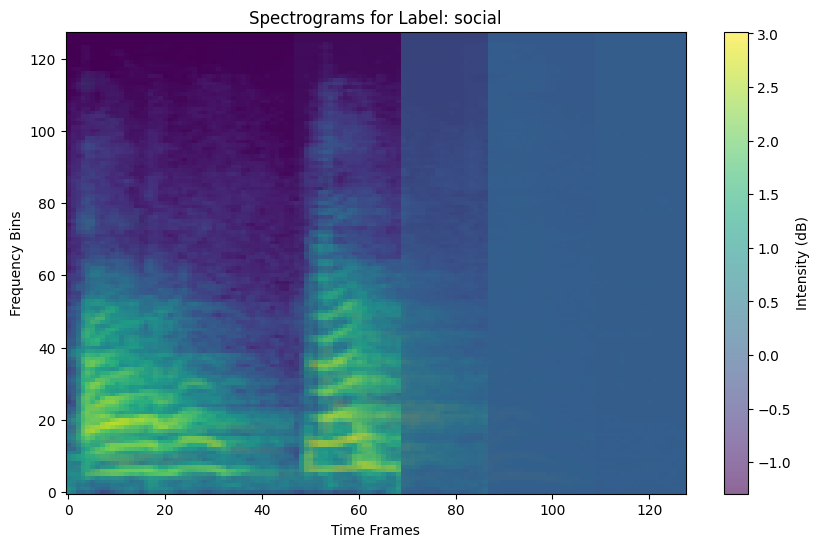

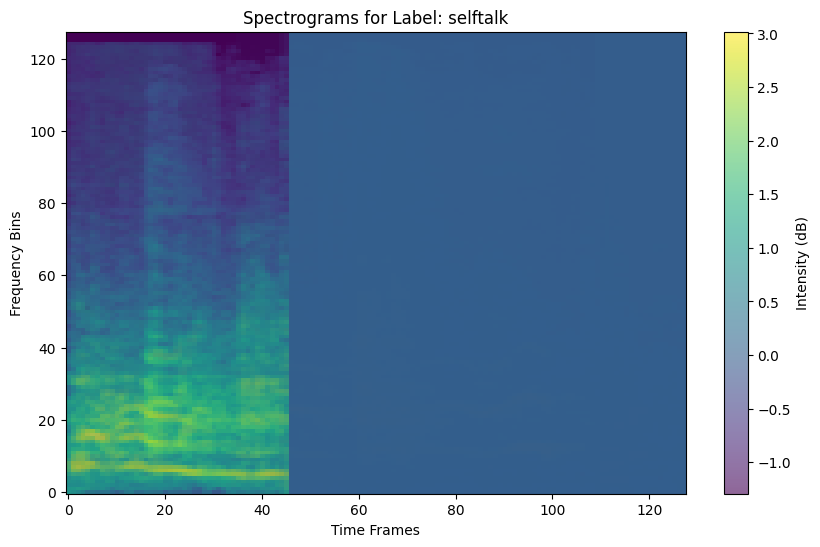

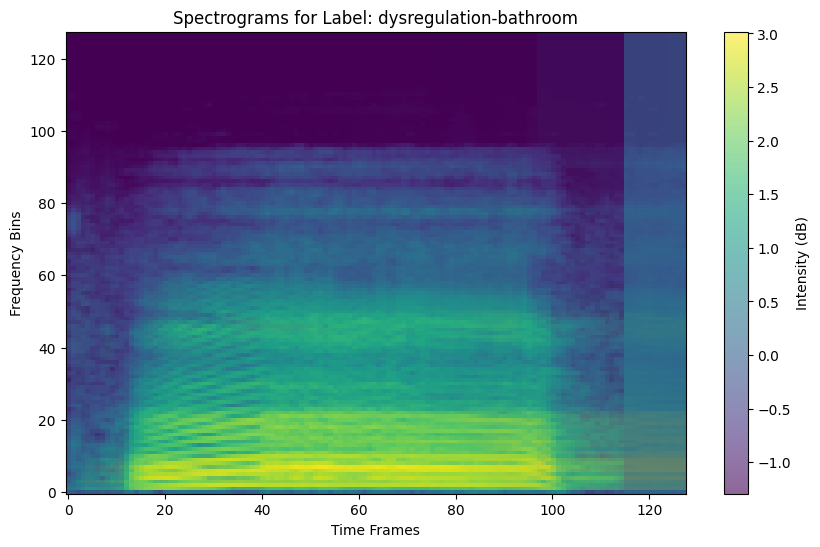

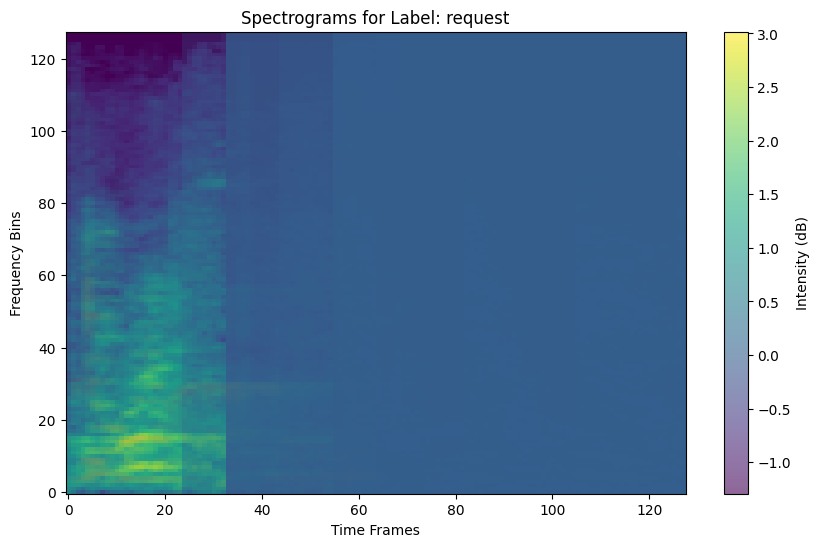

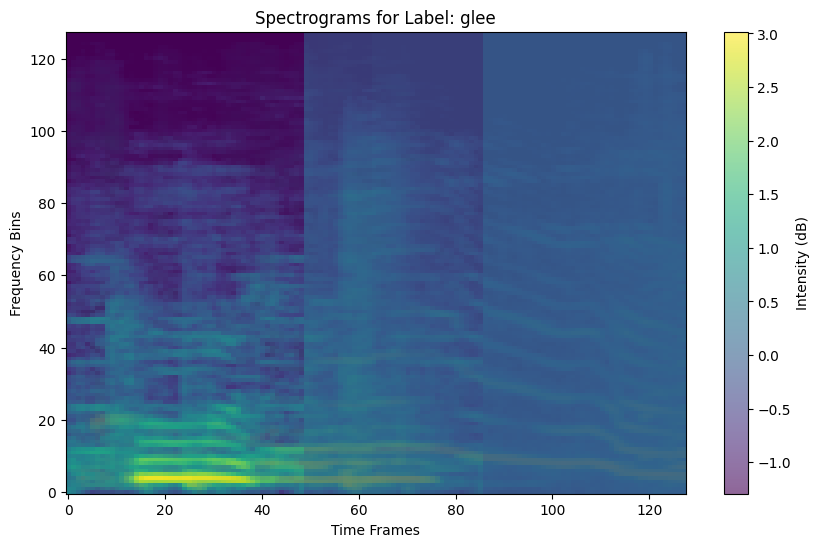

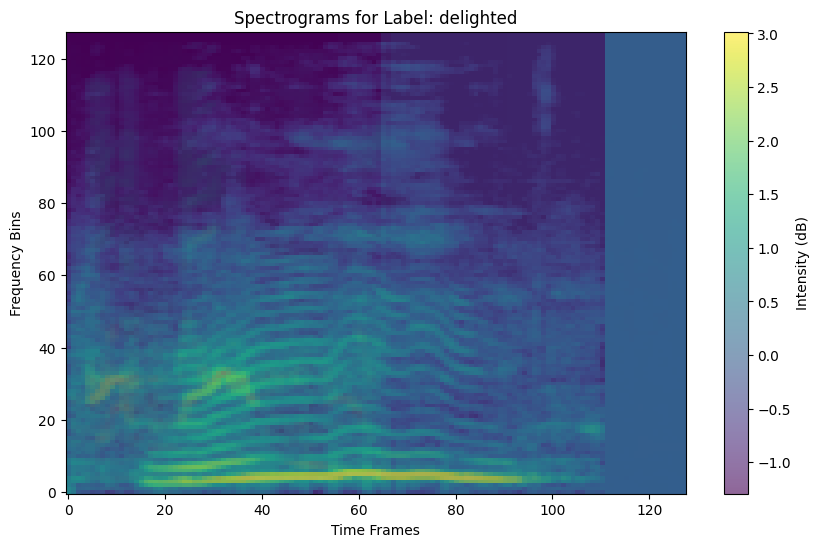

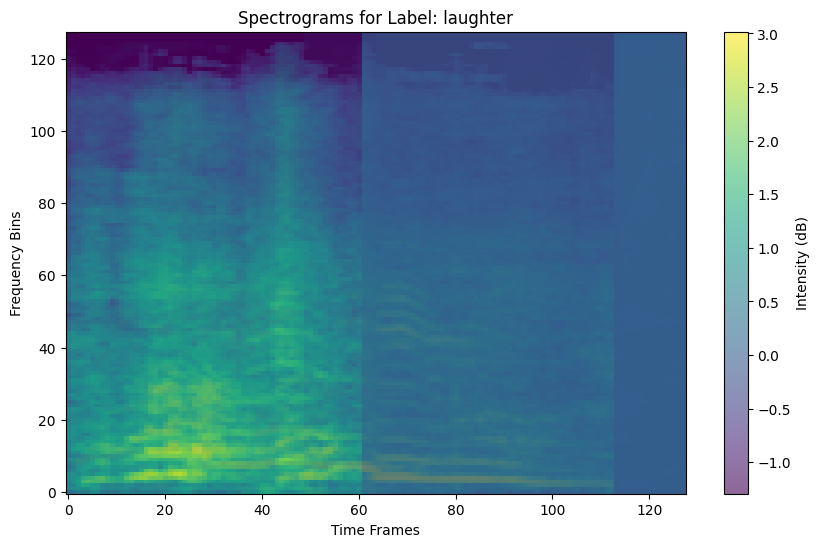

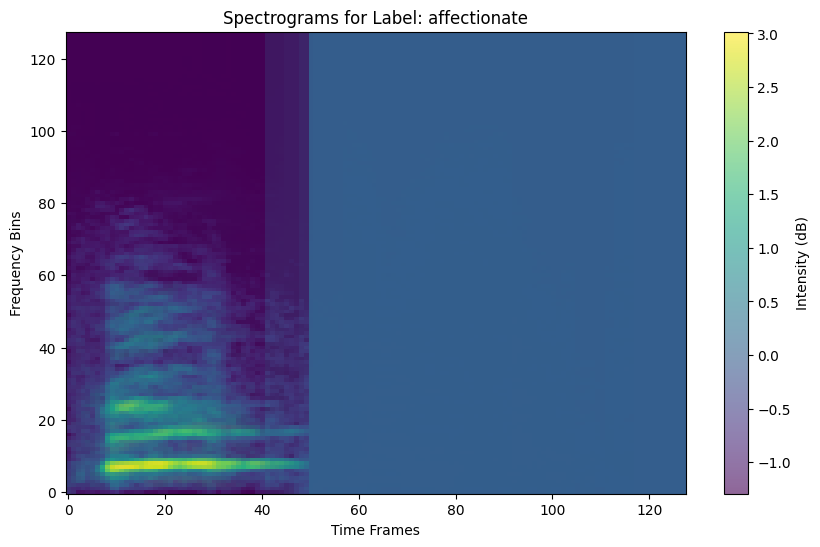

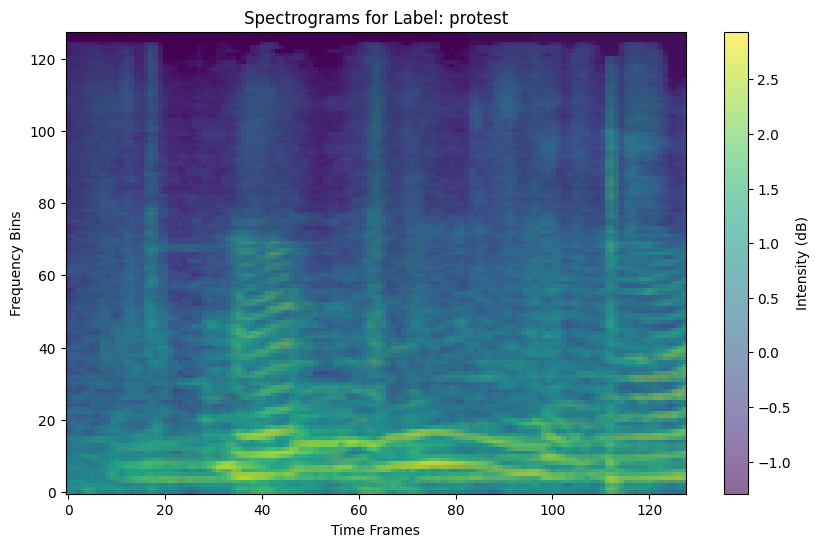

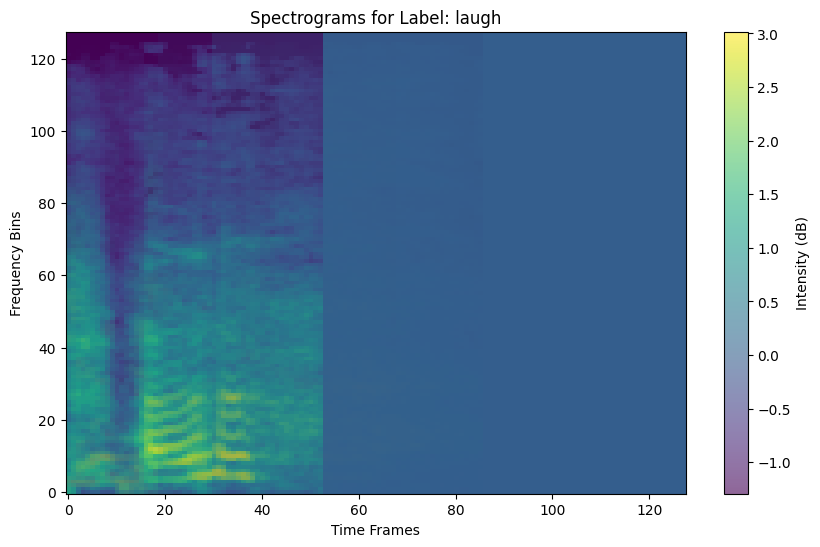

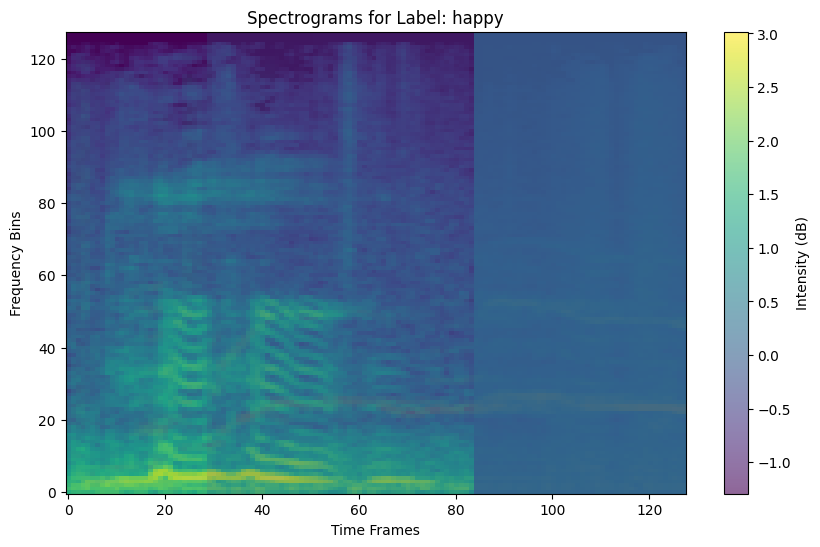

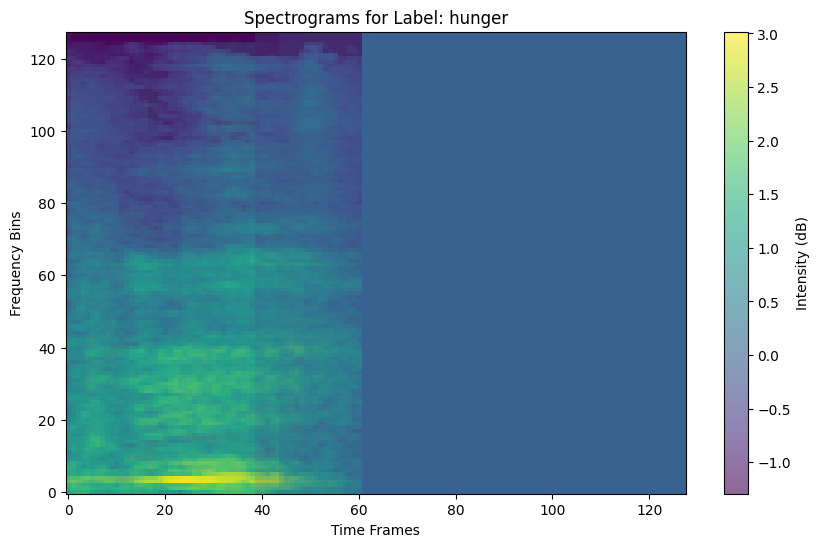

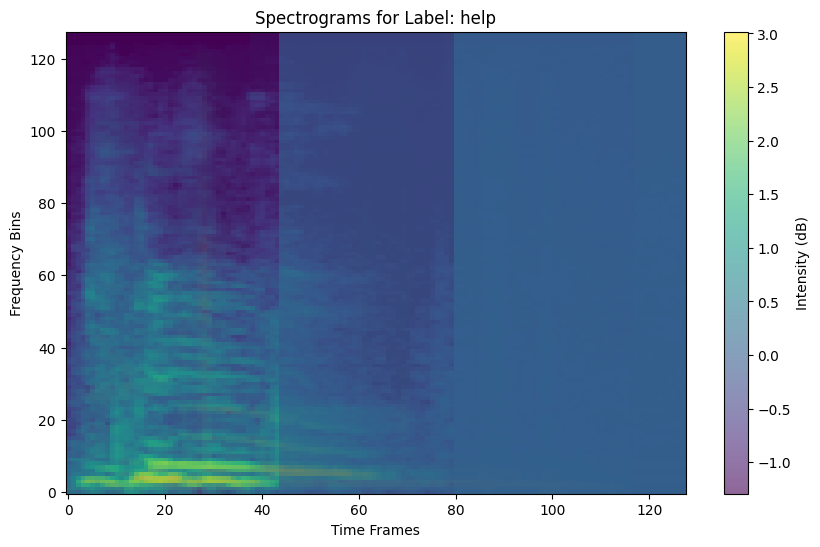

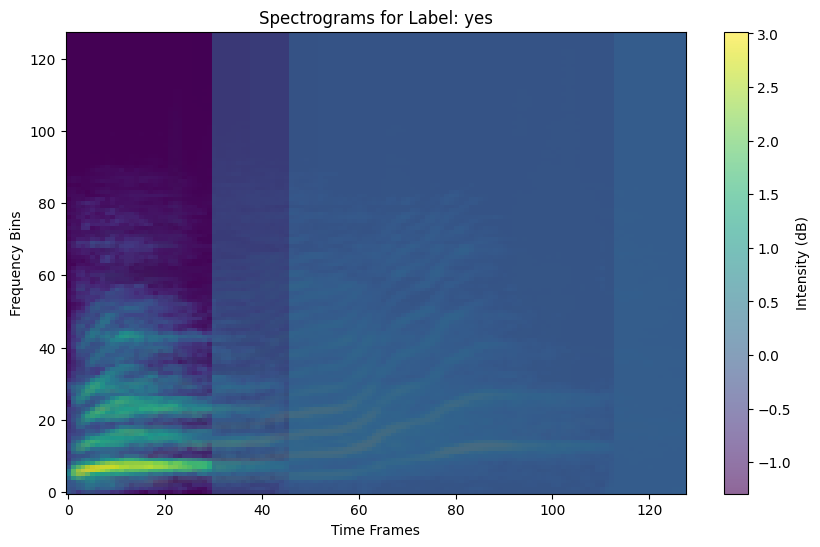

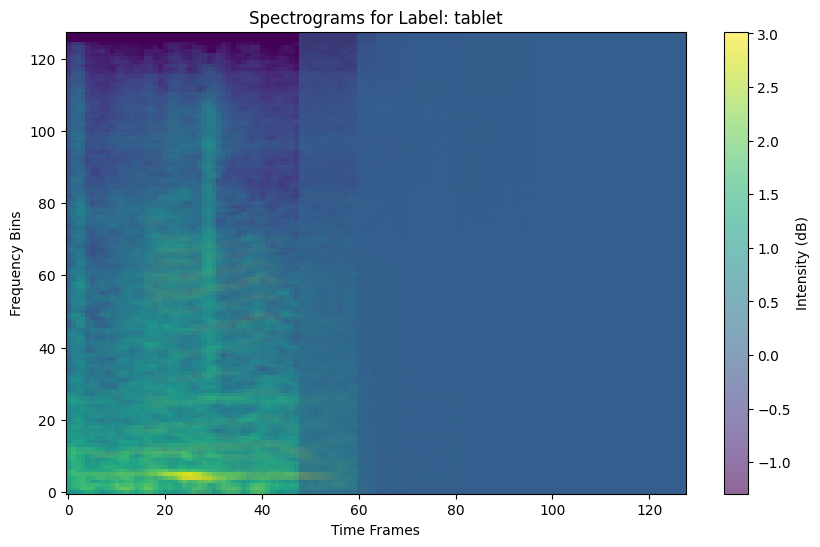

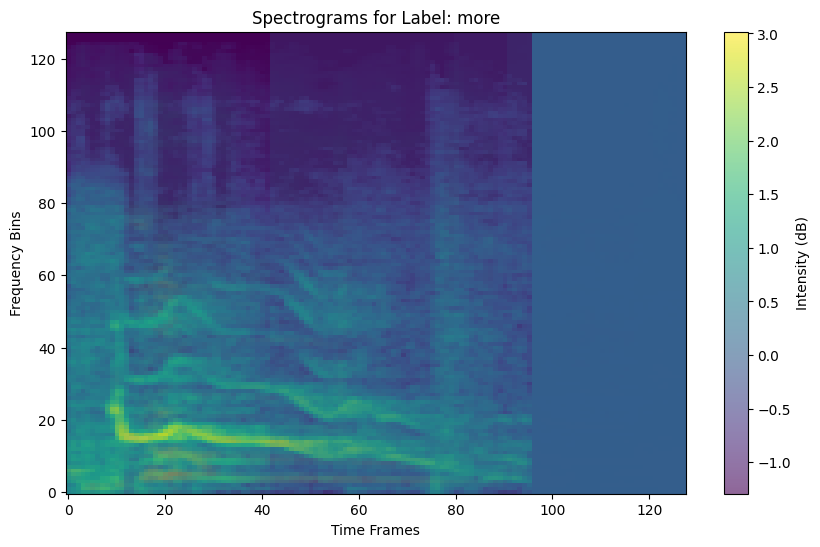

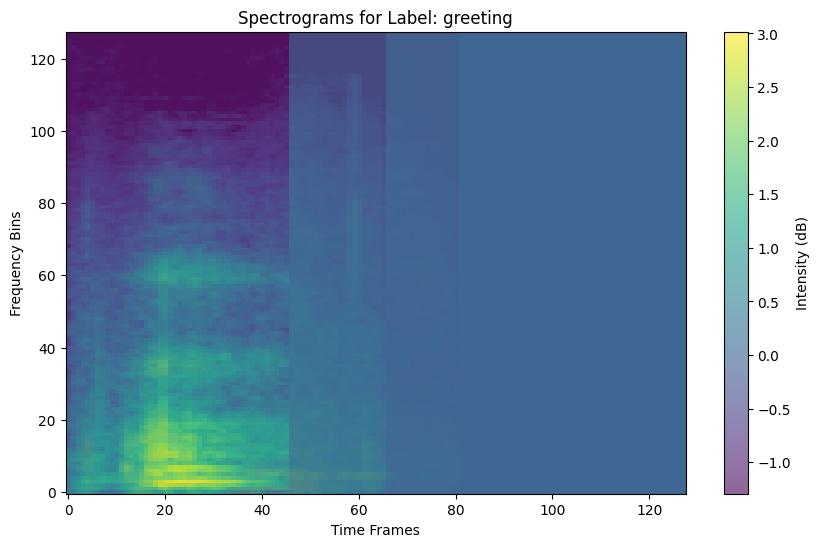

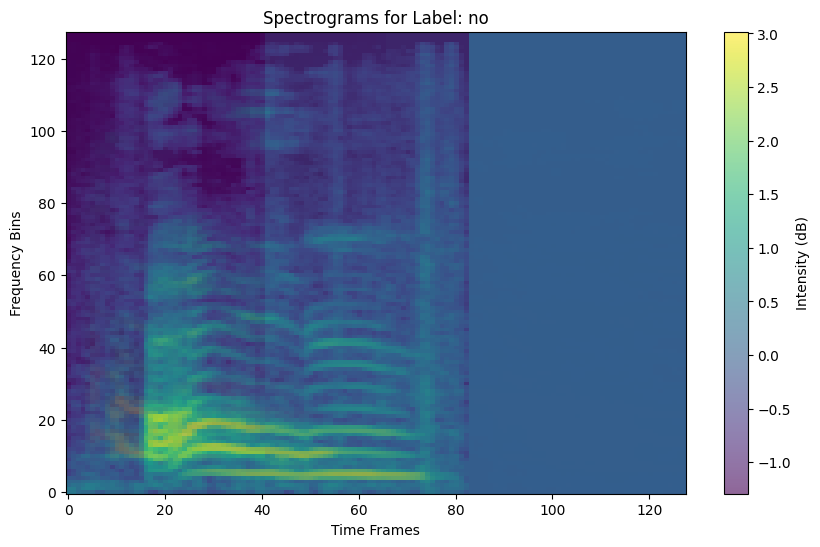

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

# Function to plot spectrograms for each label using Polars
def plot_spectrograms_per_label(df):
    # Create an empty dictionary to store spectrograms by label
    spectrograms_by_label = {}

    # Loop through rows and organize spectrograms by label
    for row in df.iter_rows(named=True):
        label = row["Label"]
        spectrogram = np.array(row["Spectrogram"])

        if label not in spectrograms_by_label:
            spectrograms_by_label[label] = []

        spectrograms_by_label[label].append(spectrogram)

    # Plot spectrograms for each label
    for label, spectrograms in spectrograms_by_label.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Spectrograms for Label: {label}")

        # Loop through the spectrograms and plot them
        for spectrogram in spectrograms:
            plt.imshow(spectrogram, aspect="auto", origin="lower", cmap="viridis", alpha=0.6)

        # Add colorbar and labels
        plt.colorbar(label="Intensity (dB)")
        plt.xlabel("Time Frames")
        plt.ylabel("Frequency Bins")
        plt.show()

# Example call to the function with the Polars DataFrame
plot_spectrograms_per_label(df)